In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import skew
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#Pass all of the data, both test and train, into our cleaning function.
#Leave Id and SalePrice out because we don't want our model to predict from these.
all_df = pd.concat((train_df.drop(['Id', 'SalePrice'], axis=1),
                      test_df.drop('Id', axis=1)))

In [22]:
def clean_data(df):
    numeric_vars = df.select_dtypes(['float64', 'int64']).columns
    data_numeric = df[numeric_vars]
    
    skewed_feats = data_numeric.apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    
    data_numeric[skewed_feats] = np.log1p(data_numeric[skewed_feats])
    
    data_cat = df.select_dtypes(['object'])
    
    result_df = pd.concat([pd.get_dummies(data_cat),data_numeric], axis=1)
    return result_df.fillna(result_df.mean())

In [23]:
data_numeric = all_df[all_df.select_dtypes(['float64', 'int64']).columns]
skewed_feats = data_numeric.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [24]:
data_all = clean_data(all_df)

/Users/tchen/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [25]:
data_train_all = data_all[:train_df.shape[0]]
data_test_all = data_all[train_df.shape[0]:]

In [26]:
X = data_train_all.values
y = np.log1p(train_df['SalePrice'].values)

In [27]:
def get_mse(X, y, a):
    x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)


    regr = linear_model.Ridge(alpha = a, normalize=True)
    regr.fit(x_train, y_train)
    return np.sqrt(np.mean((np.log(regr.predict(x_validation) )- np.log(y_validation))** 2))

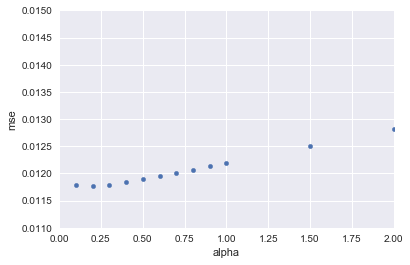

In [28]:
alpha_optimization_df = pd.DataFrame({'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5,2, 3, 4, 5, 10, 100]})
alpha_optimization_df['mse'] = alpha_optimization_df['alpha'].apply(lambda a: get_mse(X, y, a))
alpha_optimization_df.plot(x = 'alpha', y = 'mse', kind = 'scatter', xlim = [0, 2], ylim = [0.011, 0.015])

In [29]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)

#regr = linear_model.LinearRegression()
regr = linear_model.Ridge(alpha = 0.7, normalize=True)
regr.fit(x_train, y_train)
#print('Coefficients: ', regr.coef_)
print('Intercept: ', regr.intercept_)
print("Root Mean squared error: %.3f" % np.sqrt(np.mean((np.log(regr.predict(x_validation) )- np.log(y_validation))** 2)))
print("Percent error: %.4f" % np.mean(abs((regr.predict(x_validation) - y_validation) / y_validation)))

Intercept:  11.59148464
Root Mean squared error: 0.012
Percent error: 0.0078


Percent error: 0.1005


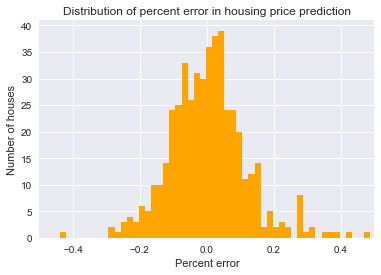

In [61]:
err = (np.expm1(regr.predict(x_validation))- np.expm1(y_validation))/np.expm1(y_validation)
print("Percent error: %.4f" % np.mean(abs((np.expm1(regr.predict(x_validation))- np.expm1(y_validation))/np.expm1(y_validation))))
plt.hist(err, bins = 200, facecolor = "orange")
plt.xlim([-0.5, 0.5])
plt.xlabel("Percent error")
plt.ylabel("Number of houses")
plt.title("Distribution of percent error in housing price prediction")
plt.savefig("error.png")

<class 'numpy.ndarray'>


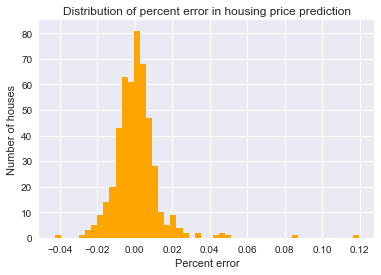

In [53]:
x = (regr.predict(x_validation) - y_validation) / y_validation
print(type(x))
plt.hist(x, 50, facecolor = "orange")
plt.xlabel("Percent error")
plt.ylabel("Number of houses")
plt.title("Distribution of percent error in housing price prediction")
plt.savefig("error.png")

In [49]:
model_lasso = linear_model.LassoCV().fit(x_train, y_train)
X_test = data_test_all.values
lasso_preds = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test_df.Id, "SalePrice":lasso_preds})
solution.to_csv("lasso_sol.csv", index = False)
print("Percent error: %.4f" % np.mean(abs((model_lasso.predict(x_validation) - y_validation) / y_validation)))

Percent error: 0.1748


/Users/tchen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
preds = regr.predict(X_test)
preds = np.expm1(preds)

In [43]:
solution = pd.DataFrame({"id":test_df.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [44]:
solution.head()

,SalePrice,id
0,126961.098305,1461
1,157139.908028,1462
2,180197.685043,1463
3,199090.872393,1464
4,193331.087621,1465


In [45]:
X = data_train_all.values
y = train_df['SalePrice'].values

In [46]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)

#regr = linear_model.LinearRegression()
lasso = linear_model.Lasso(alpha = 70, normalize=False)
lasso.fit(x_train, y_train)
print('Coefficients: ', regr.coef_)
print('Intercept: ', regr.intercept_)
print("Root Mean squared error: %.3f" % np.sqrt(np.mean((np.log(regr.predict(x_validation) )- np.log(y_validation))** 2)))
print("Percent error: %.4f" % np.mean(abs((lasso.predict(x_validation) - y_validation) / y_validation)))

Coefficients:  [ -1.98886579e-01   2.68388844e-02   3.94996893e-02   1.51520025e-02
  -1.82597151e-02  -4.68841000e-02   4.68841000e-02  -4.56582626e-03
   2.21349375e-02   1.42705701e-03   1.61648708e-02   2.04969085e-04
  -3.39504653e-03  -1.06289397e-02   1.35239073e-02  -1.52035801e-03
  -4.00777339e-04   7.25225908e-02  -7.25225908e-02   7.11803932e-03
   2.64408466e-02  -2.95686589e-02  -2.38226306e-02  -8.84687815e-03
  -1.24986919e-02   1.72571411e-02  -1.80526786e-02  -1.23839107e-02
   0.00000000e+00  -1.34236056e-02   5.01752311e-03   3.32289043e-02
  -4.02670367e-03   8.05015016e-02  -3.93707755e-02  -2.14055767e-02
  -3.81276726e-02  -7.32192576e-02  -2.26350422e-02  -1.12011053e-02
   1.08902090e-02  -3.09458799e-03   7.52038317e-02   4.88643154e-02
  -2.17264483e-02  -3.84712257e-03  -2.03272162e-02  -1.28750494e-03
   3.13368127e-02   9.14393006e-02   2.01046749e-03   5.03684052e-02
  -3.39861810e-02  -1.45233316e-02   1.99627500e-02  -5.57731704e-03
   6.11443224e-03  

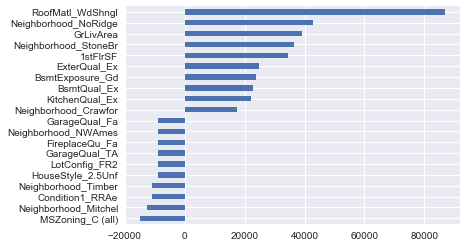

In [47]:
coef = pd.Series(lasso.coef_, index = data_all.columns)
imp = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp.plot(kind = "barh")
plt.savefig("coef.png")

In [27]:
data_all.max() - data_all.min()

MSZoning_C (all)           1.000000
MSZoning_FV                1.000000
MSZoning_RH                1.000000
MSZoning_RL                1.000000
MSZoning_RM                1.000000
Street_Grvl                1.000000
Street_Pave                1.000000
Alley_Grvl                 1.000000
Alley_Pave                 1.000000
LotShape_IR1               1.000000
LotShape_IR2               1.000000
LotShape_IR3               1.000000
LotShape_Reg               1.000000
LandContour_Bnk            1.000000
LandContour_HLS            1.000000
LandContour_Low            1.000000
LandContour_Lvl            1.000000
Utilities_AllPub           1.000000
Utilities_NoSeWa           1.000000
LotConfig_Corner           1.000000
LotConfig_CulDSac          1.000000
LotConfig_FR2              1.000000
LotConfig_FR3              1.000000
LotConfig_Inside           1.000000
LandSlope_Gtl              1.000000
LandSlope_Mod              1.000000
LandSlope_Sev              1.000000
Neighborhood_Blmngtn       1